## PyTorch Conditional GAN

From 6 inputs to 20 outputs (Response Spectrum)

In [1]:
# Importing all necessary libraries
%matplotlib inline
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
import random

In [2]:
# Run this if you have an Nvidia GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [3]:
# # Run this if it's a macbook
# # device = "mps" if torch.backends.mps.is_available() else "cpu"
# device='cpu'
# print(f"Device: {device}")

In [4]:
# Paths for mat files with the real data
input_path = "/content/drive/MyDrive/Earthquakes/Sample Data/input.mat"
output_path = "/content/drive/MyDrive/Earthquakes/Sample Data/output.mat"
period_path = "/content/drive/MyDrive/Earthquakes/Sample Data/period.mat"

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# # Defining paths to save the models
# CGAN_B_GENERATOR_PATH = (
#     "/Users/sam/Desktop/Projects/Earthquakes/Final_GAN/Models/CGAN_bg_model.df5"
# )
# CGAN_B_DISCRIMINATOR_PATH = (
#     "/Users/sam/Desktop/Projects/Earthquakes/Final_GAN/Models/CGAN_bd_model.hdf5"
# )

# CGAN_GENERATOR_PATH = (
#     "/Users/sam/Desktop/Projects/Earthquakes/Final_GAN/Models/CGAN_g_model.df5"
# )
# CGAN_DISCRIMINATOR_PATH = (
#     "/Users/sam/Desktop/Projects/Earthquakes/Final_GAN/Models/CGAN_d_model.hdf5"
# )

# res = "/Users/sam/Desktop/Projects/Earthquakes/Final_GAN/results.csv"

In [7]:
input_data = loadmat(input_path)  # load mat-file
output_data = loadmat(output_path)
period_data = loadmat(period_path)
input_data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACA64, Created on: Wed Apr 10 15:38:34 2024',
 '__version__': '1.0',
 '__globals__': [],
 'input_final': array([[  7.96      , 407.259911  ,   6.00945158,   6.453625  ,
         103.7969    ,   1.        ],
        [  7.96      , 773.9751669 ,   6.65153979,   6.453625  ,
         103.7969    ,   1.        ],
        [  7.78      , 820.3849816 ,   6.70977372,   6.453625  ,
          29.7262    ,   0.        ],
        ...,
        [  5.9       , 475.217     ,   6.16377154,   3.        ,
          89.        ,   1.        ],
        [  5.9       , 219.0065    ,   5.38910141,   3.        ,
          89.        ,   1.        ],
        [  5.9       , 244.1915    ,   5.49795275,   3.        ,
          89.        ,   1.        ]])}

In [8]:
input_df = pd.DataFrame(input_data['input_final'])
output_df = pd.DataFrame(output_data['target_final'][:,2:])
period_arr = np.array(period_data['period'][0])
print(input_df.shape, output_df.shape)


(20255, 6) (20255, 20)


In [9]:
# This is the array containing values of the periods for 20 RS values
period_arr


array([0.01 , 0.02 , 0.03 , 0.04 , 0.05 , 0.075, 0.1  , 0.12 , 0.15 ,
       0.17 , 0.2  , 0.25 , 0.3  , 0.4  , 0.5  , 0.75 , 1.   , 2.   ,
       3.   , 4.   ])

In [10]:
input_df # This has inputs for conditioning

,0,1,2,3,4,5
0,7.96,407.259911,6.009452,6.453625,103.7969,1.0
1,7.96,773.975167,6.651540,6.453625,103.7969,1.0
2,7.78,820.384982,6.709774,6.453625,29.7262,0.0
3,7.28,196.542941,5.280881,6.453625,49.8000,1.0
4,7.21,722.717951,6.583019,6.453625,29.4000,0.0
...,...,...,...,...,...,...
20250,5.50,177.628200,5.179693,3.000000,35.0000,0.0
20251,5.90,154.591500,5.040786,2.000000,89.0000,1.0
20252,5.90,475.217000,6.163772,3.000000,89.0000,1.0
20253,5.90,219.006500,5.389101,3.000000,89.0000,1.0


In [11]:
input_df[:][2].min() # Checking anomalous values

-inf

In [12]:
# Removing anomalous rows from input and output data
rows_to_remove = input_df[input_df[:][2] == input_df[:][2].min()].index

# Drop these rows from the DataFrame
input_df.drop(rows_to_remove, inplace=True)
output_df.drop(rows_to_remove, inplace=True)

In [13]:
input_df # Cleaned input data

,0,1,2,3,4,5
0,7.96,407.259911,6.009452,6.453625,103.7969,1.0
1,7.96,773.975167,6.651540,6.453625,103.7969,1.0
2,7.78,820.384982,6.709774,6.453625,29.7262,0.0
3,7.28,196.542941,5.280881,6.453625,49.8000,1.0
4,7.21,722.717951,6.583019,6.453625,29.4000,0.0
...,...,...,...,...,...,...
20250,5.50,177.628200,5.179693,3.000000,35.0000,0.0
20251,5.90,154.591500,5.040786,2.000000,89.0000,1.0
20252,5.90,475.217000,6.163772,3.000000,89.0000,1.0
20253,5.90,219.006500,5.389101,3.000000,89.0000,1.0


In [14]:
# Normalizing input data (min-max)
def normalize_column(column):
    min_val = column.min(skipna=True)
    max_val = column.max(skipna=True)
    return (column - min_val) / (max_val - min_val)


# Apply normalization to each column
normalized_df=pd.concat([input_df.apply(normalize_column)])

In [15]:
normalized_df # Final normalized inputs

,0,1,2,3,4,5
0,0.771654,0.407376,0.884241,0.837082,0.549691,0.2
1,0.771654,0.774583,0.967067,0.837082,0.549691,0.2
2,0.736220,0.821055,0.974579,0.837082,0.145750,0.0
3,0.637795,0.196377,0.790260,0.837082,0.255222,0.2
4,0.624016,0.723257,0.958228,0.837082,0.143971,0.0
...,...,...,...,...,...,...
20250,0.287402,0.177437,0.777207,0.389122,0.174511,0.0
20251,0.366142,0.154369,0.759289,0.259415,0.468997,0.2
20252,0.366142,0.475424,0.904148,0.389122,0.468997,0.2
20253,0.366142,0.218870,0.804220,0.389122,0.468997,0.2


In [16]:
from IPython.display import clear_output
# To help with readability by reducing unnecessary output

In [17]:
cond = []

0.5064295567170267
0.20381510106288717


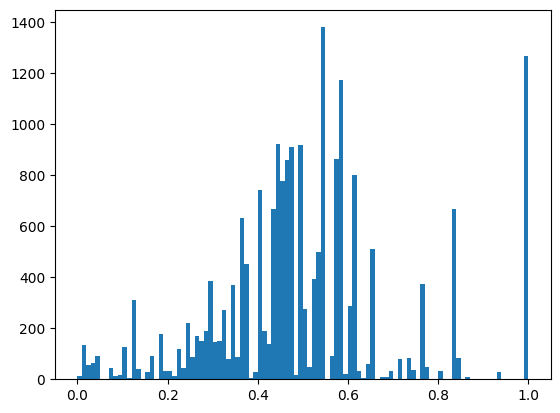

In [18]:
# Distribution of the first column
plt.hist(normalized_df[0], bins=100)
clear_output(wait=True)
print(np.mean(normalized_df[0]))
print(np.std(normalized_df[0]))
cond.append((np.mean(normalized_df[0]), np.std(normalized_df[0])))

0.26824305206458837
0.19371347754231735


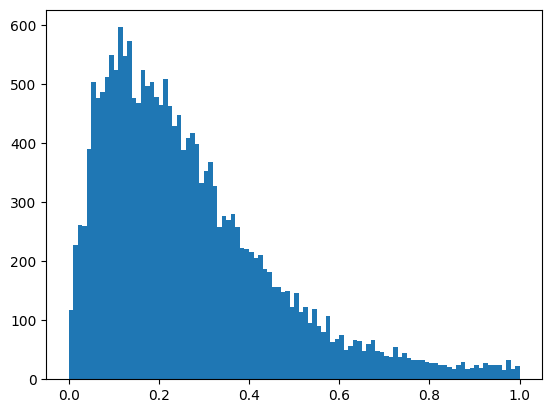

In [19]:
# Distribution of the second column
plt.hist(normalized_df[1], bins=100)
clear_output(wait=True)
print(np.mean(normalized_df[1]))
print(np.std(normalized_df[1]))
cond.append((np.mean(normalized_df[1]), np.std(normalized_df[1])))

In [20]:
print(cond)

[(0.5064295567170267, 0.20381510106288717), (0.26824305206458837, 0.19371347754231735)]


0.7923348930211817
0.11039466437061478


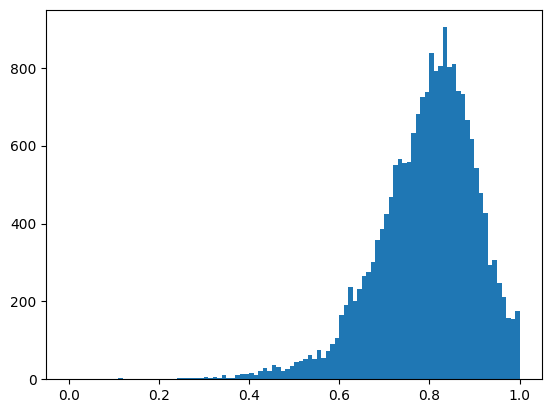

In [21]:
# Distribution of the third column
plt.hist(normalized_df[2], bins=100)
clear_output(wait=True)
print(np.mean(normalized_df[2]))
print(np.std(normalized_df[2]))
cond.append((np.mean(normalized_df[2]), np.std(normalized_df[2])))

0.7698780014829935
0.07074113929550412


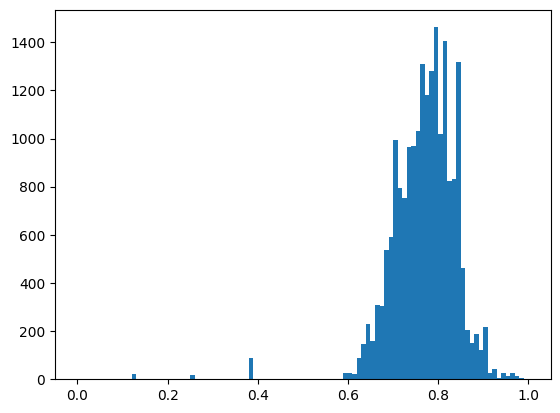

In [22]:
# Distribution of the fourth column
plt.hist(normalized_df[3], bins=100)
clear_output(wait=True)
print(np.mean(normalized_df[3]))
print(np.std(normalized_df[3]))
cond.append((np.mean(normalized_df[3]), np.std(normalized_df[3])))

0.2455312074899889
0.16795805767552666


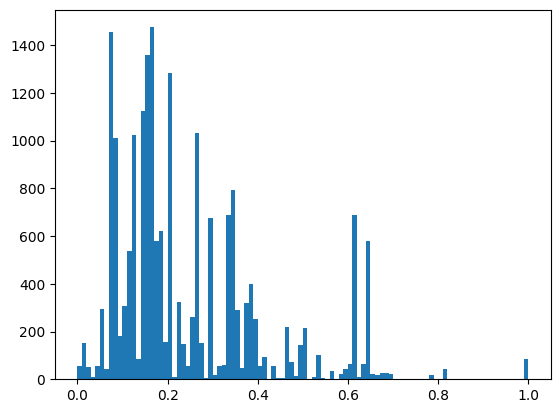

In [23]:
# Distribution of the fourth column
plt.hist(normalized_df[4], bins=100)
clear_output(wait=True)
print(np.mean(normalized_df[4]))
print(np.std(normalized_df[4]))
cond.append((np.mean(normalized_df[4]), np.std(normalized_df[4])))

0.14331370899915896
0.2344040853048446


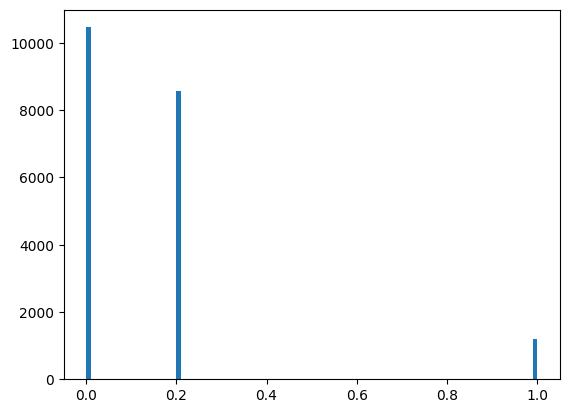

In [24]:

# Distribution of the fifth column
plt.hist(normalized_df[5], bins=100)
clear_output(wait=True)
print(np.mean(normalized_df[5]))
print(np.std(normalized_df[5]))
cond.append((np.mean(normalized_df[5]), np.std(normalized_df[5])))

In [25]:
cond

[(0.5064295567170267, 0.20381510106288717),
 (0.26824305206458837, 0.19371347754231735),
 (0.7923348930211817, 0.11039466437061478),
 (0.7698780014829935, 0.07074113929550412),
 (0.2455312074899889, 0.16795805767552666),
 (0.14331370899915896, 0.2344040853048446)]

In [26]:
# Generating condition space
def condition_generator():
    condition = []
    for tup in cond:
        condition.append(np.random.normal(float(tup[0]), float(tup[1])))
    return condition

In [27]:
condition_generator()

[0.7083533029424982,
 0.3177405781691194,
 0.9079484824794324,
 0.8104400797691041,
 0.3200265377434609,
 -0.22316224467209045]

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test_temp = train_test_split(normalized_df, test_size=0.3)
X_val, X_test = train_test_split(X_test_temp, test_size=0.5)

In [29]:
y_train, y_test_temp = train_test_split(output_df, test_size=0.3)
y_val, y_test = train_test_split(y_test_temp, test_size=0.5)

In [30]:
train_dataT = torch.tensor(np.array(X_train))

In [31]:
train_outputT = torch.tensor(np.array(y_train))

In [32]:
val_dataT = torch.tensor(np.array(X_val))
test_dataT = torch.tensor(np.array(X_test))

In [33]:
val_outputT = torch.tensor(np.array(y_val))
test_outputT = torch.tensor(np.array(y_test))

Now let's define the generator and the discriminator, which are simple MLPs. I'm going to use an embedding layer for the label:

In [40]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.embedding_layer = nn.Linear(6, 20)

        self.model = nn.Sequential(
            nn.Linear(40, 30),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(30, 25),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(25, 20),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(20, 1),
            nn.Sigmoid(),
        )

    def forward(self, x, labels):
        # print(f"x: {x.shape}, labels: {labels.shape}")
        c = self.embedding_layer(labels).long()
        # print(f"x: {x.shape}, c: {c.shape}")
        x = torch.hstack([x, c]).float()
        out = self.model(x.flatten())
        # print(f"out: {out.shape}")
        return out

In [64]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(12, 14),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(14, 15),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(15, 16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(16, 17),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(17, 18),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(18, 20),
        )

    def forward(self, z, labels):
        # print(f"z: {z.shape}, labels: {labels.shape}")
        x = torch.hstack([z, labels]).float()
        out = self.model(x.flatten())
        return out.squeeze() # This is the output of the generator

In [65]:
generator = Generator()
discriminator = Discriminator()

In [66]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=800e-6)
g_optimizer = torch.optim.Adam(generator.parameters(), lr= 800e-6)

In [67]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = torch.randn(6)
    fake_labels = torch.tensor(condition_generator())
    fake_arrays = generator(z, fake_labels)
    validity = discriminator(fake_arrays, fake_labels)
    g_loss = criterion(validity, torch.tensor([1]).float())
    g_loss.backward()
    g_optimizer.step()
    return g_loss

In [68]:
train_dataT

tensor([[0.6122, 0.1900, 0.7860, 0.7418, 0.3459, 0.2000],
        [0.6535, 0.2678, 0.8302, 0.7878, 0.0820, 0.0000],
        [0.4783, 0.1663, 0.7688, 0.7966, 0.1772, 0.0000],
        ...,
        [0.4232, 0.6306, 0.9406, 0.8578, 0.8197, 0.2000],
        [0.5276, 0.4714, 0.9031, 0.7911, 0.1472, 0.0000],
        [0.3799, 0.0541, 0.6247, 0.6716, 0.2501, 0.2000]], dtype=torch.float64)

In [69]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, input, output):
    d_optimizer.zero_grad()

    # train with real arrays

    real_validity = discriminator(output.float(), input.float())
    real_loss = criterion(real_validity, torch.ones(batch_size))

    # train with fake arrays
    z = torch.randn(6)
    fake_labels = torch.tensor(condition_generator())
    fake_arrays = generator(z, fake_labels)

    fake_validity = discriminator(fake_arrays, fake_labels)
    fake_loss = criterion(fake_validity, torch.zeros(batch_size))

    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss

In [70]:
# def generator_train_step(
#     batch_size, discriminator, generator, g_optimizer, criterion, dataT
# ):
#     g_optimizer.zero_grad()
#     z = Variable(
#         torch.randn(batch_size, 36)
#     )
#     fake_labels = Variable(torch.LongTensor(np.random.randint(0, 6, batch_size)))
#     fake_arrays = generator(z, fake_labels)
#     validity = discriminator(fake_arrays, z)
#     g_loss = criterion(validity, torch.ones(batch_size))
#     g_loss.backward()
#     g_optimizer.step()
#     return g_loss.item()


# def discriminator_train_step(
#     batch_size,
#     discriminator,
#     generator,
#     d_optimizer,
#     criterion,
#     dataT,
#     outputT,
# ):
#     d_optimizer.zero_grad()

#     # train with actual arrays
#     real_arrays = outputT.float()
#     labels = dataT.float()
#     real_validity = discriminator(real_arrays, labels)
#     real_loss = criterion(real_validity, torch.ones(batch_size))

#     # train with fake arrays
#     fake_arrays = generator(labels)
#     fake_validity = discriminator(fake_arrays, labels)
#     fake_loss = criterion(fake_validity, torch.zeros(batch_size))

#     d_loss = real_loss + fake_loss
#     d_loss.backward()
#     d_optimizer.step()
#     return d_loss.item()

In [71]:
data_loader = []
for i in range(len(train_dataT)):
    data_loader.append((train_dataT[i], train_outputT[i]))

In [72]:
train_outputT

tensor([[-3.1274, -3.0957, -2.9679,  ..., -6.3340, -6.4123, -6.8268],
        [-8.4966, -8.4945, -8.4920,  ..., -7.7244, -7.7737, -8.3017],
        [-3.8736, -3.8526, -3.8203,  ..., -7.6282, -8.2985, -8.7507],
        ...,
        [-5.8814, -5.8771, -5.8399,  ..., -6.2881, -6.6483, -7.2943],
        [-3.7079, -3.7073, -3.7062,  ..., -2.8515, -3.1803, -3.7063],
        [-5.5439, -5.5332, -5.5232,  ..., -7.3505, -8.2538, -9.0806]],
       dtype=torch.float64)

In [73]:
train_outputT

tensor([[-3.1274, -3.0957, -2.9679,  ..., -6.3340, -6.4123, -6.8268],
        [-8.4966, -8.4945, -8.4920,  ..., -7.7244, -7.7737, -8.3017],
        [-3.8736, -3.8526, -3.8203,  ..., -7.6282, -8.2985, -8.7507],
        ...,
        [-5.8814, -5.8771, -5.8399,  ..., -6.2881, -6.6483, -7.2943],
        [-3.7079, -3.7073, -3.7062,  ..., -2.8515, -3.1803, -3.7063],
        [-5.5439, -5.5332, -5.5232,  ..., -7.3505, -8.2538, -9.0806]],
       dtype=torch.float64)

Starting epoch 0...
g_loss: 0.752669632434845, d_loss: 1.143538475036621


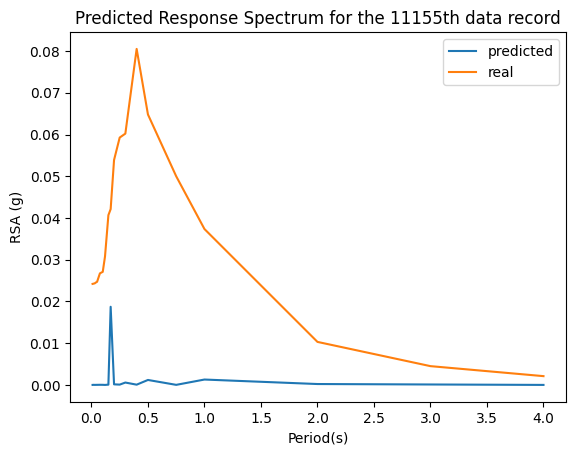

Starting epoch 1...
g_loss: 0.6481500864028931, d_loss: 1.3747670650482178


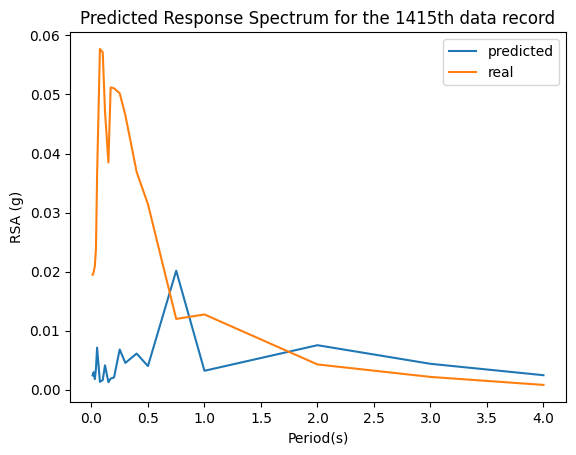

Starting epoch 2...
g_loss: 0.8901665210723877, d_loss: 1.2691621780395508


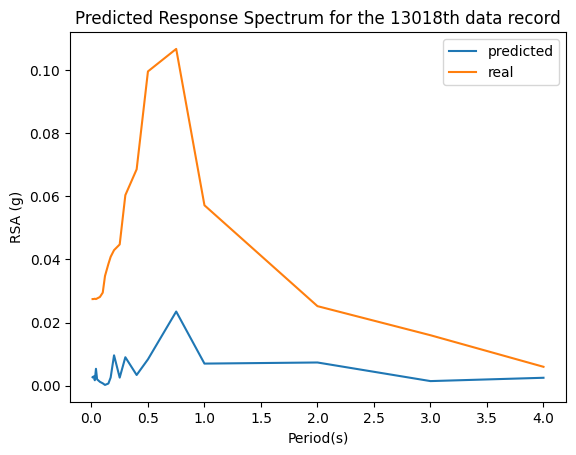

Starting epoch 3...
g_loss: 0.5675429105758667, d_loss: 1.3682975769042969


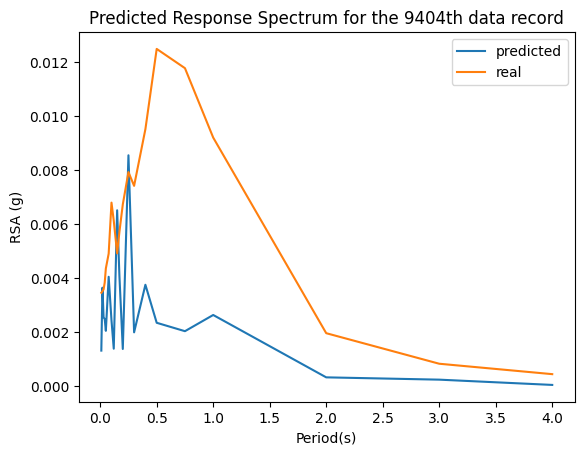

Starting epoch 4...
g_loss: 0.9603450298309326, d_loss: 1.1714767217636108


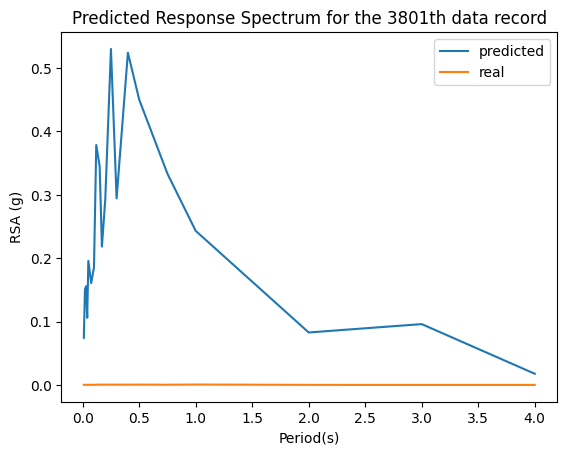

Starting epoch 5...
g_loss: 0.7405280470848083, d_loss: 1.3824776411056519


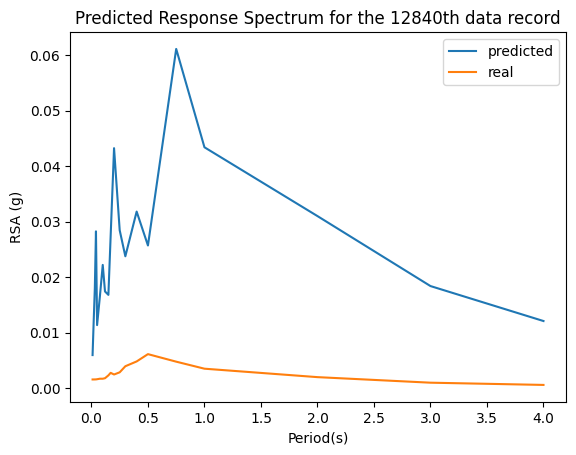

Starting epoch 6...
g_loss: 0.7828841209411621, d_loss: 1.465431571006775


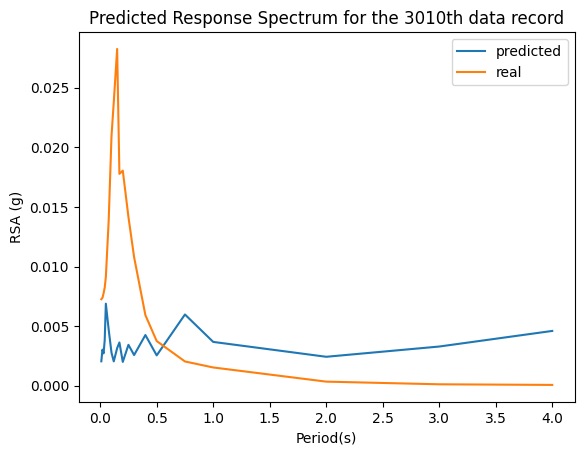

Starting epoch 7...
g_loss: 0.5581637620925903, d_loss: 1.5289700031280518


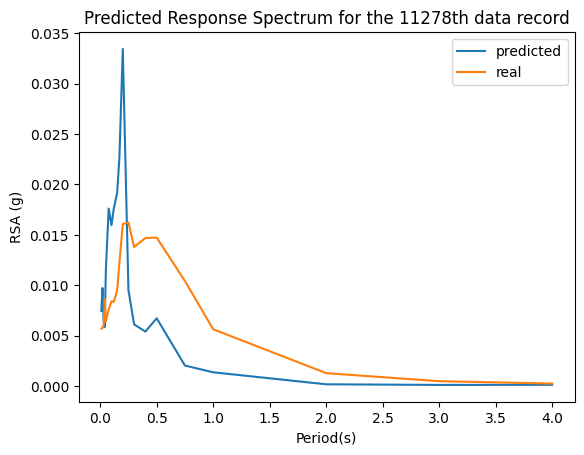

Starting epoch 8...
g_loss: 0.6350200176239014, d_loss: 1.2068946361541748


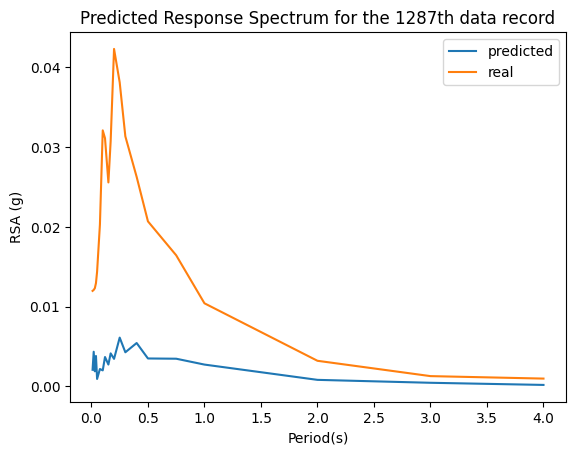

Starting epoch 9...
g_loss: 0.6014859080314636, d_loss: 1.3595904111862183


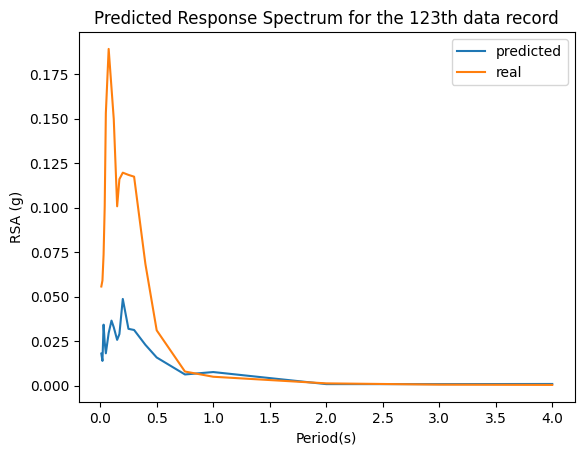

Starting epoch 10...
g_loss: 0.6965272426605225, d_loss: 1.5110969543457031


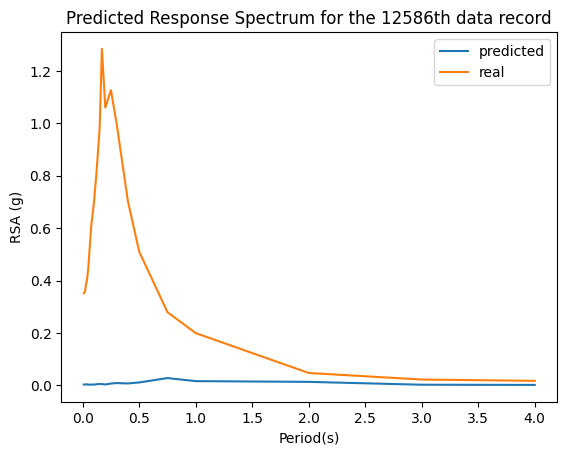

Starting epoch 11...
g_loss: 0.7188177704811096, d_loss: 1.4038292169570923


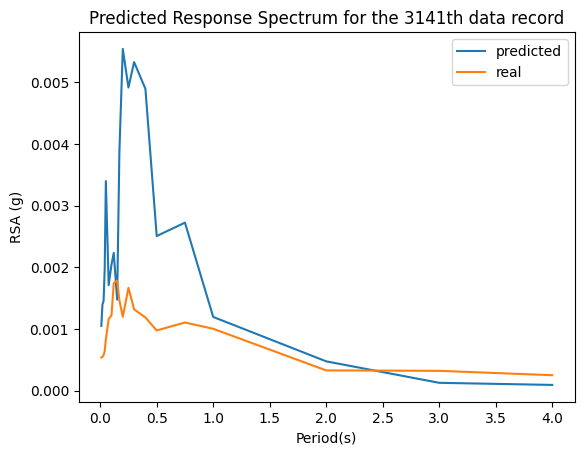

Starting epoch 12...
g_loss: 0.5817055702209473, d_loss: 1.2838306427001953


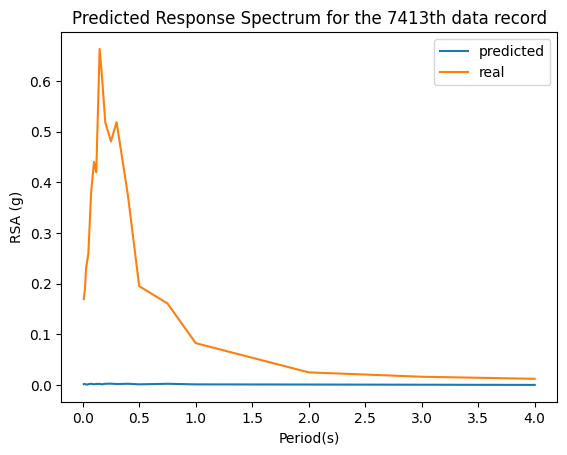

Starting epoch 13...
g_loss: 1.1232881546020508, d_loss: 1.5509536266326904


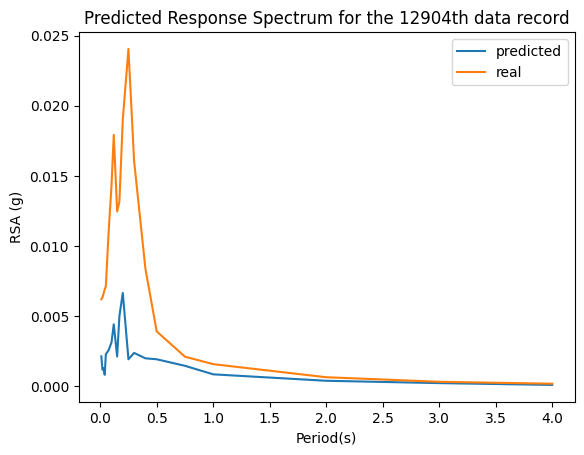

Starting epoch 14...
g_loss: 0.8959016799926758, d_loss: 1.7565441131591797


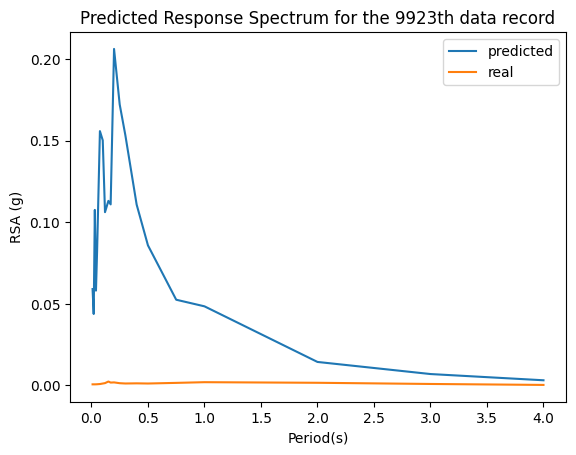

Starting epoch 15...
g_loss: 0.6510313749313354, d_loss: 1.469147801399231


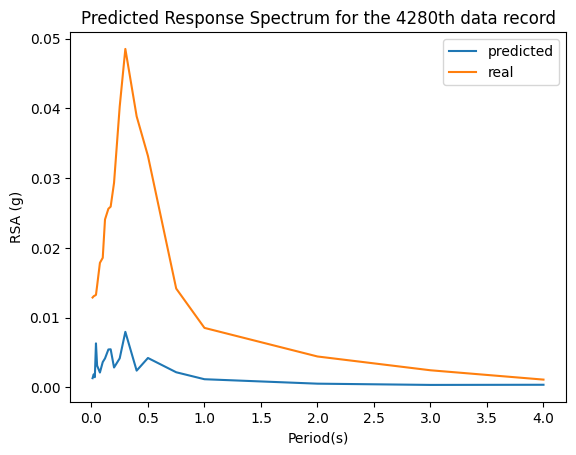

Starting epoch 16...
g_loss: 0.6652395725250244, d_loss: 1.323296070098877


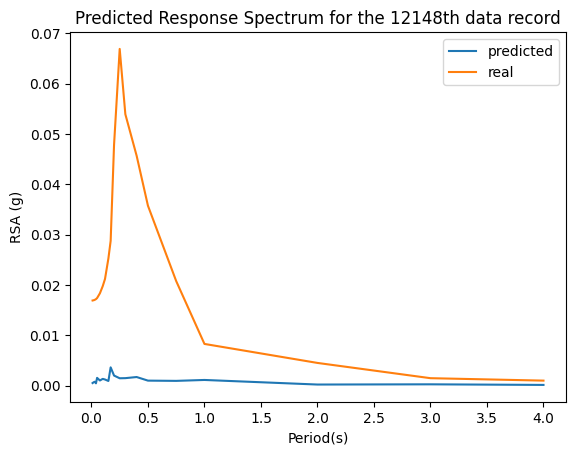

Starting epoch 17...
g_loss: 0.7195996046066284, d_loss: 1.4555447101593018


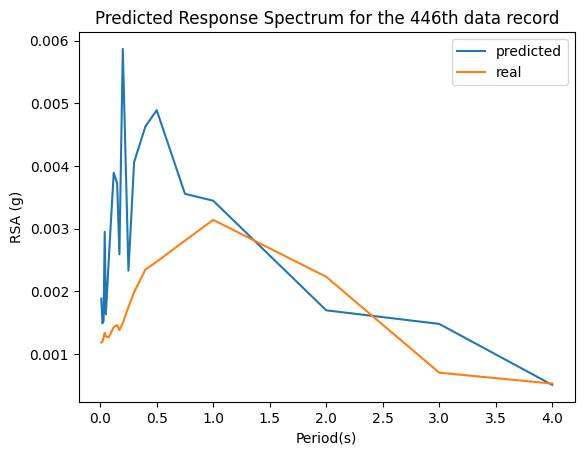

Starting epoch 18...
g_loss: 0.8305151462554932, d_loss: 1.348420262336731


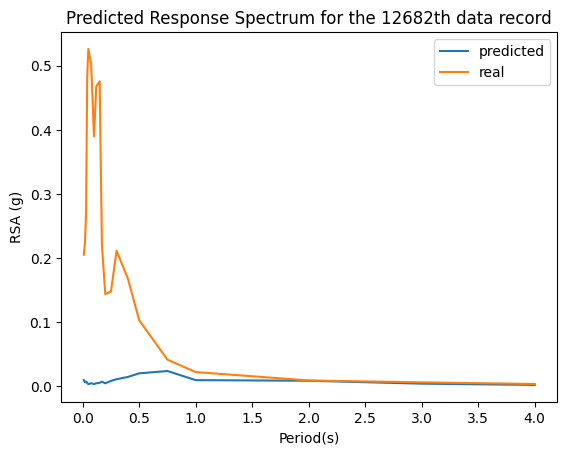

Starting epoch 19...
g_loss: 0.7355601191520691, d_loss: 1.7469217777252197


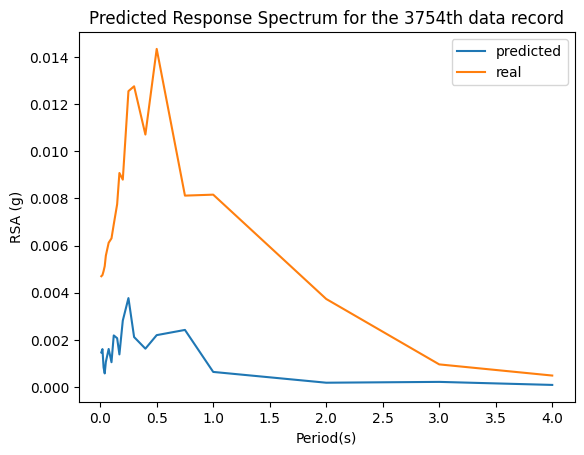

In [74]:
# Function inputs: batch_size, discriminator, generator, d_optimizer, criterion, real_arrays, labels
num_epochs = 20
# n_critic = 5
display_step = 30
for epoch in range(num_epochs):
    print("Starting epoch {}...".format(epoch))
    for i, (inp, out) in enumerate(data_loader):

        generator.train()

        d_loss = discriminator_train_step(
            1,
            discriminator,
            generator,
            d_optimizer,
            criterion,
            inp,
            out,
        )

        g_loss = generator_train_step(
            1, discriminator, generator, g_optimizer, criterion
        )

    generator.eval()
    print("g_loss: {}, d_loss: {}".format(g_loss, d_loss))
    z = torch.randn(6)
    random_int = random.randint(0,len(train_dataT)-1)
    labels = train_dataT[random_int]

    # Plot data on the first subplot
    plt.plot(period_arr, np.exp(generator(z,labels).detach().numpy()), label="predicted")
    plt.xlabel('Period(s)')
    plt.ylabel('RSA (g)')
    plt.title(f'Predicted Response Spectrum for the {random_int}th data record')
    plt.plot(period_arr, np.exp(train_outputT[random_int]), label="real")
    plt.legend()


    plt.show()

## Results

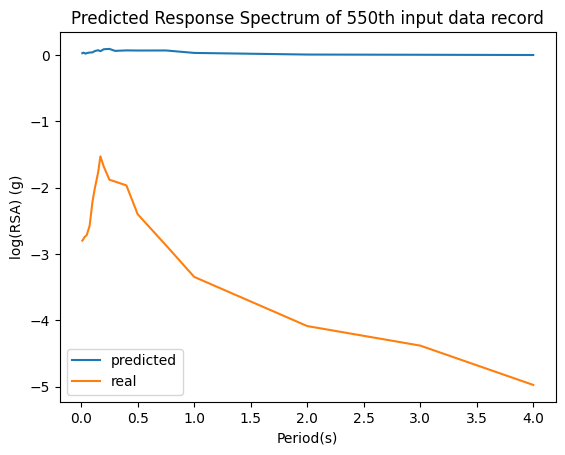

In [75]:
index = 550

z = torch.randn(6)
labels = train_dataT[index]

plt.plot(period_arr, np.exp(generator(z,labels).detach().numpy()), label="predicted")
plt.xlabel('Period(s)')
plt.ylabel('log(RSA) (g)')
plt.title(f'Predicted Response Spectrum of {index}th input data record')
plt.plot(period_arr, np.exp(train_outputT[index]), label="real")
plt.legend()
plt.show()

In [ ]:
torch.save(generator.state_dict(), "/content/drive/MyDrive/Earthquakes/Models/CGAN_generator2")
torch.save(discriminator.state_dict(), "/content/drive/MyDrive/Earthquakes/Models/CGAN_discriminator2")